In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
btc_df = pd.read_csv('full_BTCUSDT_1m.csv')
btc_df

open_time          open          high           low  \
0        1577102280000   7559.510526   7559.674211   7558.492632   
1        1577102340000   7559.421053   7559.493158   7553.792632   
2        1577102400000   7554.101579   7555.295789   7552.223158   
3        1577102460000   7552.041053   7554.945789   7551.796842   
4        1577102520000   7555.182105   7564.287895   7554.650526   
...                ...           ...           ...           ...   
2515437  1733010900000  96448.763830  96448.763830  96380.009787   
2515438  1733010960000  96380.563617  96404.250000  96376.345532   
2515439  1733011020000  96402.682553  96420.647234  96397.798085   
2515440  1733011080000  96397.799362  96397.799362  96384.759149   
2515441  1733011140000  96384.763404  96401.982766  96384.688936   

                close  volume     close_time  quote_volume  count  \
0         7559.426316       0  1577102339999             0     57   
1         7554.118947       0  1577102399999             0     60   
2         7552.940526       0  1577102459999             0     60   
3         7554.808947       0  1577102519999             0     60   
4         7564.287895       0  1577102579999             0     60   
...               ...     ...            ...           ...    ...   
2515437  96380.009787       0  1733010959999             0     60   
2515438  96402.682553       0  1733011019999             0     60   
2515439  96397.798085       0  1733011079999             0     60   
2515440  96384.759149       0  1733011139999             0     60   
2515441  96401.982766       0  1733011199999             0     60   

         taker_buy_volume  taker_buy_quote_volume  ignore  
0                       0                       0       0  
1                       0                       0       0  
2                       0                       0       0  
3                       0                       0       0  
4                       0                       0       0  
...                   ...                     ...     ...  
2515437                 0                       0       0  
2515438                 0                       0       0  
2515439                 0                       0       0  
2515440                 0                       0       0  
2515441                 0                       0       0  

[2515442 rows x 12 columns]

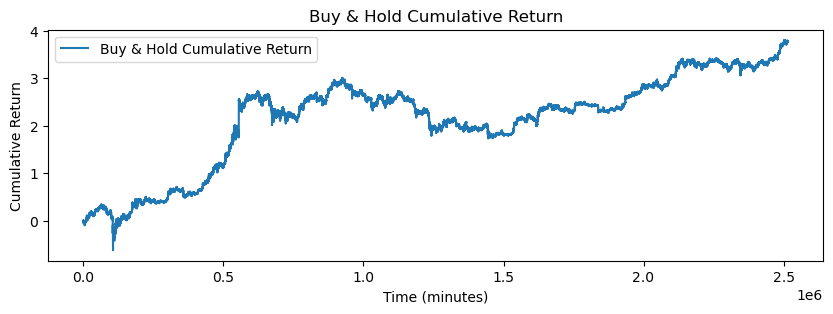

In [3]:
btc_ret = btc_df['close'] / btc_df['close'].shift(1) - 1  
btc_cum_ret = btc_ret.cumsum()  
plt.figure(figsize=(10, 3))
plt.plot(btc_cum_ret, label="Buy & Hold Cumulative Return")
plt.title("Buy & Hold Cumulative Return")
plt.xlabel("Time (minutes)")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

btc_df['ret'] = btc_df['close'].pct_change()
btc_df['ret_next'] = btc_df['ret'].shift(-3)
df = btc_df.dropna(subset=['ret', 'ret_next']).copy()

y = df['ret_next']  # ret(t+3)
X = df['ret']       # ret(t)

X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               ret_next   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     26.55
Date:                Fri, 17 Jan 2025   Prob (F-statistic):           2.57e-07
Time:                        20:11:54   Log-Likelihood:             1.3761e+07
No. Observations:             2515438   AIC:                        -2.752e+07
Df Residuals:                 2515436   BIC:                        -2.752e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.502e-06   6.42e-07      2.340      0.0

In [9]:
btc = btc_df['close'].values

In [10]:
btc

array([ 7559.42631579,  7554.11894737,  7552.94052632, ...,
       96397.79808511, 96384.75914894, 96401.98276596])

### Bluta Algo 

In [14]:
# Min-Max Indicator
def calculate_min_max_indicator(btc, window):
    btc = np.array(btc)
    min_vals = pd.Series(btc).rolling(window=window).min().to_numpy()
    max_vals = pd.Series(btc).rolling(window=window).max().to_numpy()
    # DropNa
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = np.nan 

    mm = (btc - min_vals) / (max_vals - min_vals)
    return mm

In [15]:
# Trading Algo
def generate_signals(min_max, threshold_high=0.8, threshold_low=0.2):
    signals = np.zeros(len(min_max))
    signals[min_max > threshold_high] = 1  # Long Position
    signals[min_max < threshold_low] = -1  # Short Position
    return signals

In [16]:
def simulate_trading(btc, signals, stop_loss_factor=0.02, take_profit_factor=0.04, max_holding_time=10):
    returns = []
    position_open = False
    entry_price = None
    holding_time = 0

    for i in range(len(prices)):
        if signals[i] != 0 and not position_open: 
            position_open = True
            entry_price = btc[i]
            take_profit = entry_price * (1 + take_profit_factor * signals[i])
            stop_loss = entry_price * (1 - stop_loss_factor * signals[i])
            holding_time = 0

        elif position_open:
            holding_time += 1
            if signals[i] == 1:  # Long Position
                if btc[i] >= take_profit or btc[i] <= stop_loss or holding_time >= max_holding_time:
                    returns.append((btc[i] - entry_price) / entry_price)
                    position_open = False
            elif signals[i] == -1:  # Short Position
                if btc[i] <= take_profit or btc[i] >= stop_loss or holding_time >= max_holding_time:
                    returns.append((entry_price - btc[i]) / entry_price)
                    position_open = False

    return returns

### Easy Backtest

In [17]:
# Back-Test
def run_strategy(btc, window, threshold_high=0.8, threshold_low=0.2, stop_loss_factor=0.02, take_profit_factor=0.04, max_holding_time=10):
    mm = calculate_min_max_indicator(btc, window)
    signals = generate_signals(mm, threshold_high, threshold_low)
    returns = simulate_trading(btc, signals, stop_loss_factor, take_profit_factor, max_holding_time)
    total_return = sum(returns)
    return total_return

In [18]:
window = 15  
threshold_high = 0.8
threshold_low = 0.2
stop_loss_factor = 0.02
take_profit_factor = 0.04
max_holding_time = 10  
prices = btc

total_return = run_strategy(prices, window, threshold_high, threshold_low, stop_loss_factor, take_profit_factor, max_holding_time)
print(f"Strats Return: {total_return:.2%}")

/var/folders/b6/fb60dc_d6bx6dt630rrghmbc0000gn/T/ipykernel_64467/3188723369.py:10: RuntimeWarning: invalid value encountered in divide
  mm = (btc - min_vals) / (max_vals - min_vals)


Strats Return: 37809.78%


In [20]:
mm = calculate_min_max_indicator(btc, window=15)
mm

/var/folders/b6/fb60dc_d6bx6dt630rrghmbc0000gn/T/ipykernel_64467/3188723369.py:10: RuntimeWarning: invalid value encountered in divide
  mm = (btc - min_vals) / (max_vals - min_vals)


array([       nan,        nan,        nan, ..., 0.18183064, 0.04854762,
       0.28376771])

In [21]:
signals = generate_signals(mm, threshold_high=0.8, threshold_low=0.2)


Trading Returns per times: [0.0017503642545525864, 0.001382932743017655, 0.0010135988729692103, 0.0014312179932594782, 0.0005551954287465004, 0.0023701542605630028, 0.001016131114995654, 0.0016149811098283677, 0.0013663983186202652, 0.0013296447098246082, 0.0083891970810403, 0.0008782211146705368, 0.0030291500979091495, 0.0022064793182585587, 0.0013042353349101295, 0.0018234351387776777, 0.0014298032471509142, 0.0042698417977329785, 0.0007487832527869505, 0.00917232822476176, 0.00014075608746557498, 0.007238774595086867, 0.0017858188642953135, 0.0020414235328056066, 0.0026057435548573703, 0.010375240887567033, 0.0016933048494867267, 0.007168678320047744, 0.0035547004462174524, 0.001150857676109654, 0.0017572221098414676, 0.0025641420060332687, 0.0036985687077000363, 0.002117537374947868, 0.0011396915548505565, 0.0013370585849802733, 1.1136970809938418e-05, 0.00018054887101053496, 0.0007144719232514637, 0.0013623261055005667, 0.0007642336988377124, 0.001021139366264308, 0.00113684181717

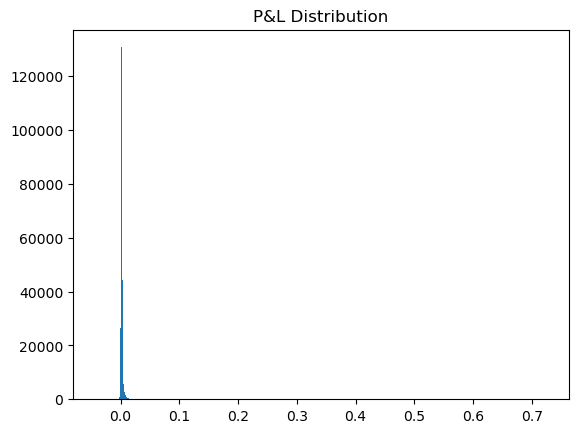

In [22]:
returns = simulate_trading(btc, signals, stop_loss_factor, take_profit_factor, max_holding_time)
print(f"Trading Returns per times: {returns}")
plt.hist(returns, bins=500)
plt.title("P&L Distribution")
plt.show();


In [23]:
print(f"Trading Signal: {signals}")
print(f"Trading times: {len(signals)}")


Trading Signal: [ 0.  0.  0. ... -1. -1.  0.]
Trading times: 2515442


In [24]:
unique, counts = np.unique(signals, return_counts=True)
signal_distribution = dict(zip(unique, counts))
print(f"Signal_distribution: {signal_distribution}")


Signal_distribution: {-1.0: 733361, 0.0: 1020857, 1.0: 761224}


Trading_times: 228739
Total_Ret: 37809.78%
Avg trading P&L: 0.1653%
Max_Ret: 72.4993%
Min_Ret: -4.2757%


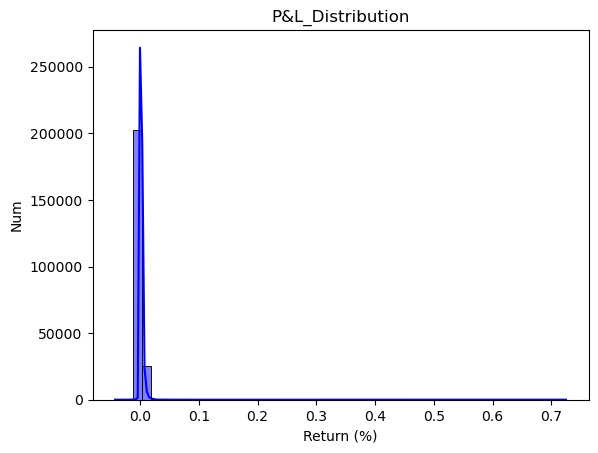

In [25]:
returns = simulate_trading(
    btc, 
    signals, 
    stop_loss_factor=0.02, 
    take_profit_factor=0.04, 
    max_holding_time=10
)

print(f"Trading_times: {len(returns)}")
print(f"Total_Ret: {sum(returns):.2%}")
print(f"Avg trading P&L: {np.mean(returns):.4%}")
print(f"Max_Ret: {np.max(returns):.4%}")
print(f"Min_Ret: {np.min(returns):.4%}")

import seaborn as sns
sns.histplot(returns, bins=50, color='blue', kde = True)
plt.title("P&L_Distribution")
plt.xlabel("Return (%)")
plt.ylabel("Num")
plt.show();


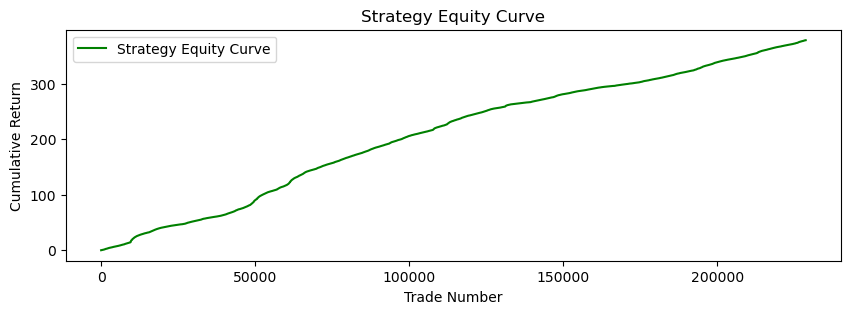

In [26]:
strategy_equity = np.cumsum(returns)  
strategy_equity = np.insert(strategy_equity, 0, 0)  

plt.figure(figsize=(10, 3))
plt.plot(strategy_equity, label="Strategy Equity Curve", color="green")
plt.title("Strategy Equity Curve")
plt.xlabel("Trade Number")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

### Optimization:
#### - Grid Search
#### - Bayesian Optimization just for fun

In [134]:
# Define grid search function
def grid_search_optimize_window(prices, window_range, threshold_high=0.8, threshold_low=0.2, stop_loss_factor=0.02, take_profit_factor=0.04, max_holding_time=10):
    best_window = None
    best_performance = float('-inf')
    results = []

    for window in window_range:
        min_max = calculate_min_max_indicator(prices, window)
        signals = generate_signals(min_max, threshold_high, threshold_low)
        returns = simulate_trading(prices, signals, stop_loss_factor, take_profit_factor, max_holding_time)
        avg_return = np.nanmean(returns)  
        total_return = np.sum(returns)  

        results.append({'window': window, 'average_return': avg_return, 'total_return': total_return})
        if avg_return > best_performance:
            best_performance = avg_return
            best_window = window

    return best_window, results

In [135]:
window_range = range(5, 51, 5)

In [136]:
best_window, optimization_results = grid_search_optimize_window(prices, window_range);

/var/folders/b6/fb60dc_d6bx6dt630rrghmbc0000gn/T/ipykernel_32342/3188723369.py:10: RuntimeWarning: invalid value encountered in divide
  mm = (btc - min_vals) / (max_vals - min_vals)


In [137]:
pd.DataFrame(optimization_results)


window  average_return  total_return
0       5        0.000483    189.347311
1      10        0.001334    356.753279
2      15        0.001653    378.097843
3      20        0.001751    362.507567
4      25        0.001792    344.985073
5      30        0.001793    327.493513
6      35        0.001781    309.627375
7      40        0.001766    296.012500
8      45        0.001750    283.793606
9      50        0.001733    273.330635

### Net Fee

In [1]:
def simulate_trading(btc, signals, stop_loss_factor=0.02, take_profit_factor=0.04, 
                    max_holding_time=10, trading_fee=0.0004):
    returns = []
    position_open = False
    entry_price = None
    holding_time = 0
    num_trades = 0  # To keep track of the number of trades

    for i in range(len(btc)):  # Corrected from 'prices' to 'btc'
        if signals[i] != 0 and not position_open: 
            position_open = True
            entry_price = btc[i]
            take_profit = entry_price * (1 + take_profit_factor * signals[i])
            stop_loss = entry_price * (1 - stop_loss_factor * signals[i])
            holding_time = 0

        elif position_open:
            holding_time += 1
            if signals[i] == 1:  # Long Position
                if btc[i] >= take_profit or btc[i] <= stop_loss or holding_time >= max_holding_time:
                    trade_return = (btc[i] - entry_price) / entry_price
                    trade_return -= 2 * trading_fee  # Subtract trading fees
                    returns.append(trade_return)
                    num_trades += 1
                    position_open = False
            elif signals[i] == -1:  # Short Position
                if btc[i] <= take_profit or btc[i] >= stop_loss or holding_time >= max_holding_time:
                    trade_return = (entry_price - btc[i]) / entry_price
                    trade_return -= 2 * trading_fee  # Subtract trading fees
                    returns.append(trade_return)
                    num_trades += 1
                    position_open = False

    return returns, num_trades

In [2]:
def run_strategy(btc, window, threshold_high=0.8, threshold_low=0.2, 
                stop_loss_factor=0.02, take_profit_factor=0.04, 
                max_holding_time=10, trading_fee=0.0004):
    mm = calculate_min_max_indicator(btc, window)
    signals = generate_signals(mm, threshold_high, threshold_low)
    returns, num_trades = simulate_trading(btc, signals, 
                                          stop_loss_factor, 
                                          take_profit_factor, 
                                          max_holding_time, 
                                          trading_fee)
    total_return = sum(returns)
    return total_return, num_trades

In [37]:

# Simulate Trading with Trading Fee
def simulate_trading(
    btc, signals, stop_loss_factor=0.02, take_profit_factor=0.04, 
    max_holding_time=10, trading_fee=0.0004
):
    returns = []
    position_open = False
    entry_price = None
    holding_time = 0
    num_trades = 0  # To keep track of the number of trades

    for i in range(len(btc)):  # Ensure 'btc' is used, not 'prices'
        if signals[i] != 0 and not position_open: 
            position_open = True
            entry_price = btc[i]
            take_profit = entry_price * (1 + take_profit_factor * signals[i])
            stop_loss = entry_price * (1 - stop_loss_factor * signals[i])
            holding_time = 0

        elif position_open:
            holding_time += 1
            if signals[i] == 1:  # Long Position
                if (btc[i] >= take_profit or 
                    btc[i] <= stop_loss or 
                    holding_time >= max_holding_time):
                    trade_return = (btc[i] - entry_price) / entry_price
                    trade_return -= 2 * trading_fee  # Subtract trading fees
                    returns.append(trade_return)
                    num_trades += 1
                    position_open = False
            elif signals[i] == -1:  # Short Position
                if (btc[i] <= take_profit or 
                    btc[i] >= stop_loss or 
                    holding_time >= max_holding_time):
                    trade_return = (entry_price - btc[i]) / entry_price
                    trade_return -= 2 * trading_fee  # Subtract trading fees
                    returns.append(trade_return)
                    num_trades += 1
                    position_open = False

    return returns, num_trades

# Back-Test Strategy
def run_strategy(
    btc, window, threshold_high=0.8, threshold_low=0.2, 
    stop_loss_factor=0.02, take_profit_factor=0.04, 
    max_holding_time=10, trading_fee=0.0004
):
    mm = calculate_min_max_indicator(btc, window)
    signals = generate_signals(mm, threshold_high, threshold_low)
    returns, num_trades = simulate_trading(
        btc, signals, stop_loss_factor, take_profit_factor, 
        max_holding_time, trading_fee
    )
    total_return = sum(returns)
    return total_return, num_trades

# Define Parameters
window = 15  
threshold_high = 0.8
threshold_low = 0.2
stop_loss_factor = 0.02
take_profit_factor = 0.04
max_holding_time = 10
trading_fee = 0.0004
btc = btc_df['close'].values

# Run the Strategy
total_return, num_trades = run_strategy(
    btc, window, threshold_high, threshold_low, 
    stop_loss_factor, take_profit_factor, 
    max_holding_time, trading_fee
)

print(f"Strategy's Return after Fees: {total_return:.2%}")
print(f"Number of Trades Executed: {num_trades}")

/var/folders/b6/fb60dc_d6bx6dt630rrghmbc0000gn/T/ipykernel_64467/2815713598.py:16: RuntimeWarning: invalid value encountered in divide
  mm = (btc - min_vals) / (max_vals - min_vals)


Strategy's Return after Fees: 19510.66%
Number of Trades Executed: 228739


In [48]:
def simulate_trading(
    btc, signals, stop_loss_factor=0.02, take_profit_factor=0.04, 
    max_holding_time=10, trading_fee=0.0004
):
    returns = []
    equity_curve = [1.0]  # Start with an initial equity of 1 (100%)
    position_open = False
    entry_price = None
    holding_time = 0
    num_trades = 0  # To keep track of the number of trades
    current_equity = 1.0  # Initial equity

    for i in range(len(btc)):
        if signals[i] != 0 and not position_open: 
            position_open = True
            entry_price = btc[i]
            take_profit = entry_price * (1 + take_profit_factor * signals[i])
            stop_loss = entry_price * (1 - stop_loss_factor * signals[i])
            holding_time = 0
            # Deduct entry trading fee
            current_equity *= (1 - trading_fee)
        
        elif position_open:
            holding_time += 1
            if signals[i] == 1:  # Long Position
                if (btc[i] >= take_profit or 
                    btc[i] <= stop_loss or 
                    holding_time >= max_holding_time):
                    trade_return = (btc[i] - entry_price) / entry_price
                    trade_return_net = trade_return - 2 * trading_fee  # Subtract entry and exit fees
                    current_equity *= (1 + trade_return_net)
                    returns.append(trade_return_net)
                    num_trades += 1
                    position_open = False
                    # Deduct exit trading fee
                    current_equity *= (1 - trading_fee)
            elif signals[i] == -1:  # Short Position
                if (btc[i] <= take_profit or 
                    btc[i] >= stop_loss or 
                    holding_time >= max_holding_time):
                    trade_return = (entry_price - btc[i]) / entry_price
                    trade_return_net = trade_return - 2 * trading_fee  # Subtract entry and exit fees
                    current_equity *= (1 + trade_return_net)
                    returns.append(trade_return_net)
                    num_trades += 1
                    position_open = False
                    # Deduct exit trading fee
                    current_equity *= (1 - trading_fee)
        
        # Append current equity to equity_curve
        equity_curve.append(current_equity)
    
    # If position is still open at the end, close it without profit/loss
    if position_open:
        current_equity *= (1 - trading_fee)  # Exit fee without any return
        equity_curve.append(current_equity)
        position_open = False

    return returns, num_trades, equity_curve

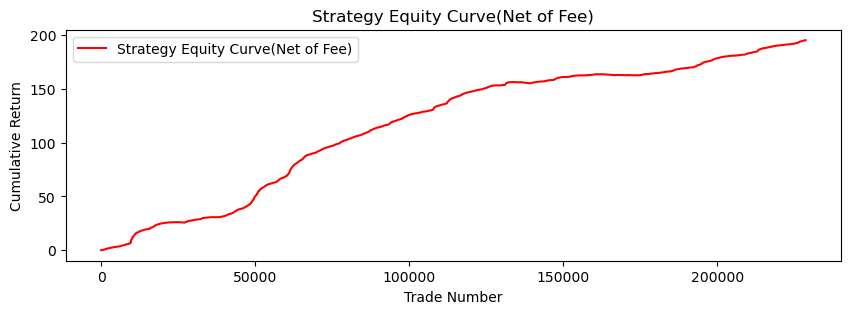

In [52]:
strategy_equity = np.cumsum(returns)  
strategy_equity = np.insert(strategy_equity, 0, 0)  

plt.figure(figsize=(10, 3))
plt.plot(strategy_equity, label="Strategy Equity Curve(Net of Fee)", color="red")
plt.title("Strategy Equity Curve(Net of Fee)")
plt.xlabel("Trade Number")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

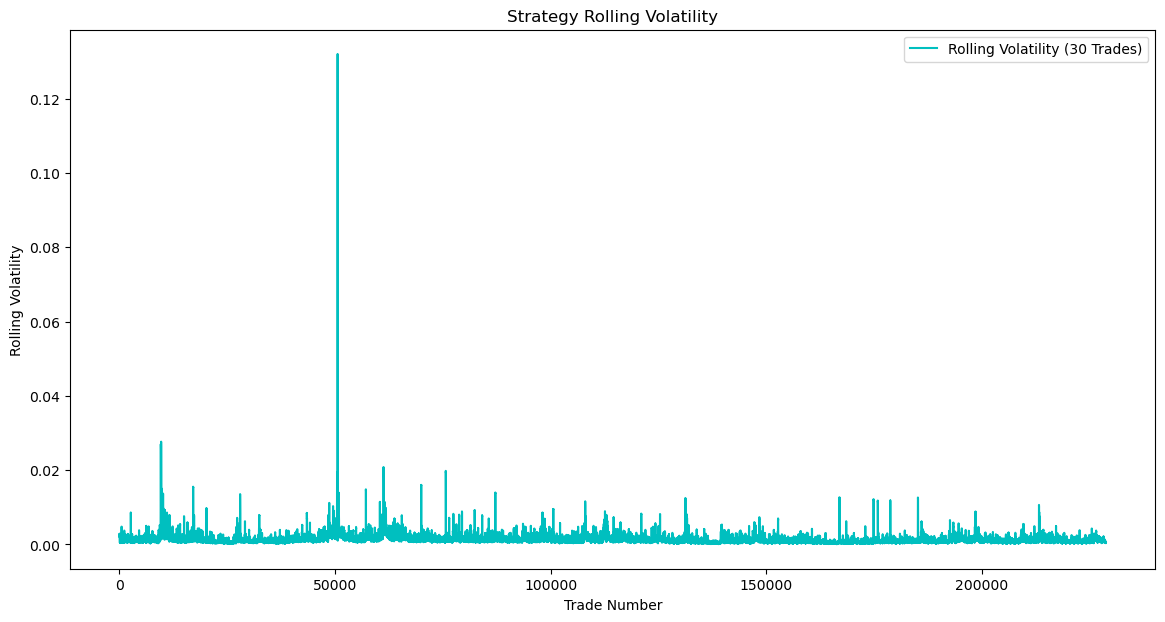

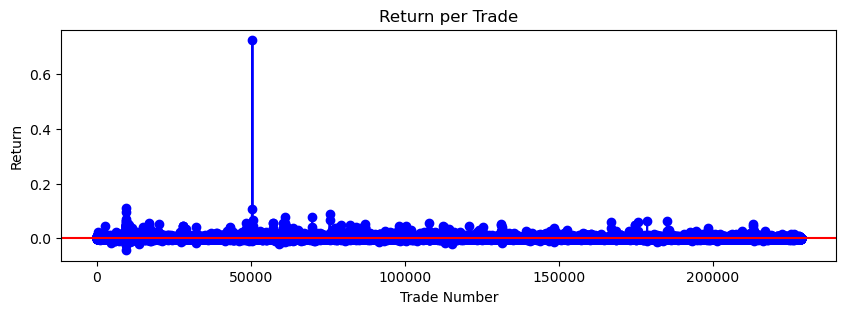

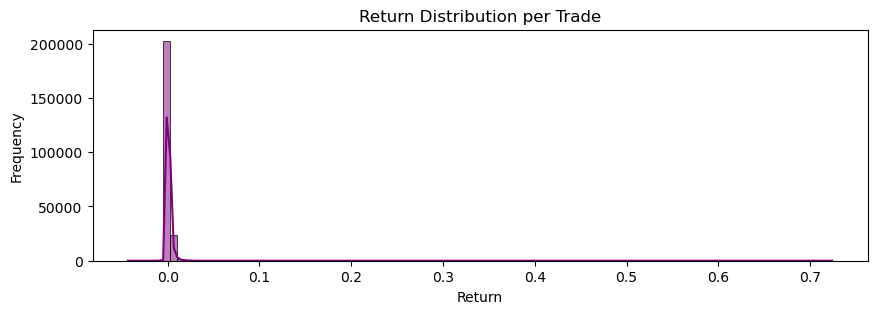

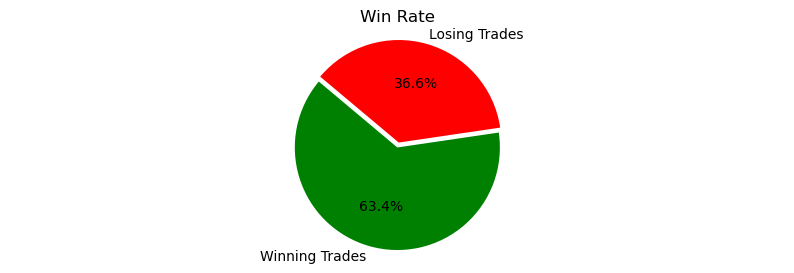

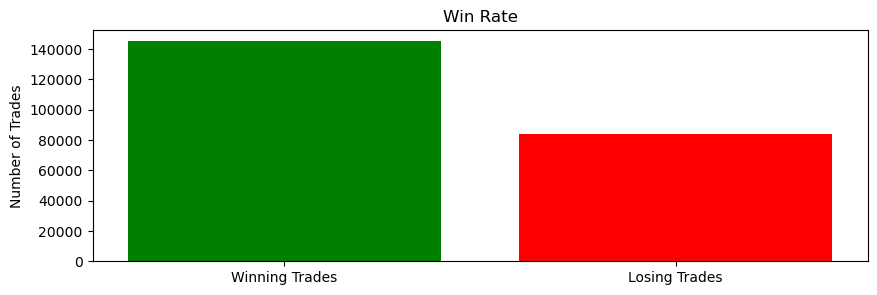

Win Rate: 63.44%


In [64]:
window = 15  
threshold_high = 0.8
threshold_low = 0.2
stop_loss_factor = 0.02
take_profit_factor = 0.04
max_holding_time = 10  
trading_fee = 0.0004
btc = btc_df['close'].values


# Run the Strategy
total_return, num_trades, returns, equity_curve = run_strategy(
    btc, window, threshold_high, threshold_low, 
    stop_loss_factor, take_profit_factor, 
    max_holding_time, trading_fee
)

returns_series = pd.Series(returns)

# Define the rolling window size for volatility (e.g., 30 trades)
rolling_window = 30

# Calculate rolling volatility (standard deviation)
rolling_volatility = returns_series.rolling(window=rolling_window).std()

# Calculate Win Rate
winning_trades = returns_series[returns_series > 0]
losing_trades = returns_series[returns_series <= 0]
win_rate = (len(winning_trades) / len(returns_series)) * 100  # Percentage

# 2. Rolling Volatility
plt.figure(figsize=(14, 7))
plt.plot(rolling_volatility, label=f"Rolling Volatility ({rolling_window} Trades)", color="c")
plt.title("Strategy Rolling Volatility")
plt.xlabel("Trade Number")
plt.ylabel("Rolling Volatility")
plt.legend()
plt.show()

# 3. Return per Trade
plt.figure(figsize=(10, 3))
plt.plot(returns, marker='o', linestyle='-', color='blue')
plt.title('Return per Trade')
plt.xlabel('Trade Number')
plt.ylabel('Return')
plt.axhline(0, color='red')
plt.show()

# 4. Return Distribution
plt.figure(figsize=(10, 3))
sns.histplot(returns, bins=100, kde=True, color='purple')
plt.title('Return Distribution per Trade')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()

# 5. Win Rate
plt.figure(figsize=(10, 3))
labels = ['Winning Trades', 'Losing Trades']
sizes = [len(winning_trades), len(losing_trades)]
colors = ['green', 'red']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=(0.05, 0))
plt.title('Win Rate')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Alternatively, display Win Rate as a Bar Chart
plt.figure(figsize=(10, 3))
plt.bar(['Winning Trades', 'Losing Trades'], [len(winning_trades), len(losing_trades)], color=['green', 'red'])
plt.title('Win Rate')
plt.ylabel('Number of Trades')
plt.show()

# Display the Win Rate percentage
print(f"Win Rate: {win_rate:.2f}%")